<a href="https://colab.research.google.com/github/Only-Mike/M2-NLP-Network-Analysis/blob/main/NLP_SC_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



In [1]:
#Installing preprocessor to celan our text
!pip install tweet-preprocessor -q

# Installing Gensim and PyLDAvis
!pip install -qq -U gensim
!pip install -qq pyLDAvis

# explainability (why did the model say it's related to this author)
!pip install eli5

     |████████████████████████████████| 24.1 MB 1.9 MB/s 
     |████████████████████████████████| 1.7 MB 9.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 14.5 MB/s 
     |████████████████████████████████| 133 kB 54.9 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=57ba71afc1ecdcc47b752f1e23ed20e41a9a7a9669cc6ac7aced21078da31039
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into a

In [2]:
import pandas as pd
import numpy as np
import tqdm #progress bar
import preprocessor as prepro # text prepro

import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module

# sampling, splitting
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# loading ML libraries
from sklearn.pipeline import make_pipeline #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model
from sklearn.metrics import classification_report #that's self explanatory
from sklearn.decomposition import TruncatedSVD #dimensionality reduction
from xgboost import XGBClassifier

import altair as alt #viz

#explainability
import eli5
from eli5.lime import TextExplainer

# topic modeling

from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA

# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%matplotlib inline
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [3]:
# prepro settings
prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.SMILEY)

In [4]:
!git clone https://github.com/Only-Mike/M2-NLP-Network-Analysis.git

Cloning into 'M2-NLP-Network-Analysis'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [ ]:
# Importing dataset

In [15]:
data1 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2017 csv file.csv')
data2 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2018 csv file.csv')
data3 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2019 csv file.csv')
data4 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2020 csv file.csv')
data5 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2021 csv file.csv')


In [16]:
frames = [data1, data2, data3, data4, data5] #creating frame for all datasets

In [17]:
df = pd.concat(frames) #Concat all datasets to "df"

In [18]:
df.shape

(8573, 22)

In [19]:
df.columns

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Cited by',
       'DOI', 'Link', 'Affiliations', 'Authors with affiliations', 'Abstract',
       'Author Keywords', 'Index Keywords', 'Funding Details',
       'Correspondence Address', 'Publisher', 'ISSN', 'ISBN', 'CODEN',
       'Document Type', 'Source', 'EID'],
      dtype='object')

# Cleaning text and embedding the data

In [20]:
#Choosing the columns we need to work with and storing them in the value "data"
data = df[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [25]:
data = data.iloc[0:1000, :] # Slice the rows to make the dataset lighter

In [27]:
#Combining the Abstract and title   ----- NEEDS ONLY ABSTRACT
data['text'] = data['Title'] + '. ' + data['Abstract']

In [28]:
#Cleaning the text
data['text_clean'] = data['text'].map(lambda t: prepro.clean(t))


In [29]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data['text_clean']),position=0, leave=True)

for text in nlp.pipe(data['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

 21%|██        | 1792/8573 [00:54<03:26, 32.76it/s] 
/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
 98%|█████████▊| 983/1000 [00:12<00:00, 185.12it/s]

In [30]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [31]:
data['text_clean'] = text_prepro(data['text'])  ##<---- HVAD GØR DEN HER?<-------##

100%|██████████| 1000/1000 [00:12<00:00, 82.39it/s]


In [32]:
# preprocess texts (we need tokens)  <---- Hvad gør den her? <------
tokens = []

for summary in nlp.pipe(data['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [33]:
data['tokens'] = tokens

In [34]:
## SPØRGSMÅL OMKRING FILTER 

# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data['tokens']]

#Model Metrics

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

In [36]:
corpus = data['tokens']

In [37]:
corpus

0      [food, nutrition, security, southern, african,...
1      [iot, cargo, monitoring, system, operational, ...
2      [annual, software, technology, conference, stc...
3      [approximation, high, dimensional, commodity, ...
4      [accessibility, local, food, production, regio...
                             ...                        
995    [successful, biogas, implementation, mini, rev...
996    [bi, objective, location, allocation, inventor...
997    [sustainable, supply, chain, uncertainty, life...
998    [process, network, design, optimisation, p, gr...
999    [network, flow, model, source, optimal, transp...
Name: tokens, Length: 1000, dtype: object

In [38]:
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

# Considering 1-15 topics, as the last is cut off
num_topics = list(range(16)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [39]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [40]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [41]:
coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence() for i in num_topics[:-1]]

In [42]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

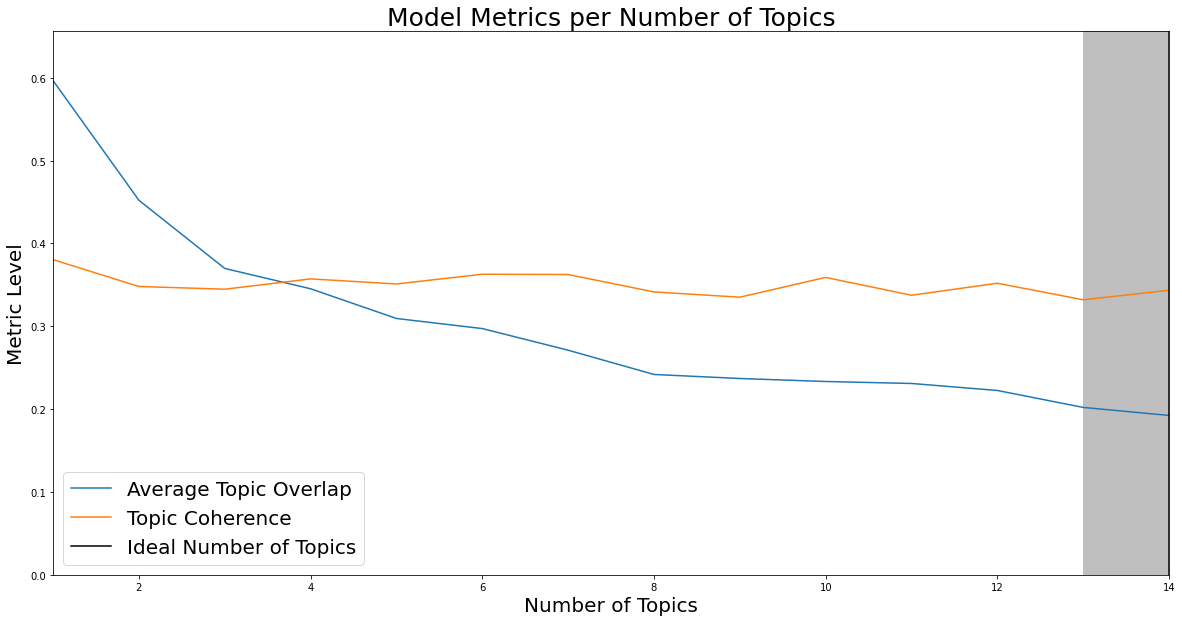

In [43]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()  

# Visualization

In [ ]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=14, workers = 4, passes=10)

Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/usr/local/lib/python3.7/dist-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py", line 767, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py", line 698, in inference
    ids = [int(idx) for idx, _ in doc]
  File "/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py", line 698, in <listcomp>
    ids = [int(idx) for idx, _ in doc]
ValueError: too many values 

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

In [ ]:
pyLDAvis.display(lda_display)